In [27]:
import os
# Reqiured to suppress tensorflow annoying warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np

import spacy
import gensim
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import re


In [3]:
df = pd.read_csv("./data/output.csv")

### Data Cleaning

In [4]:
# "review_text" nan are to be deleted. Other can stay.
df = df.dropna(subset=["review_text"])

# Remove invalid entries
df = df.loc[df["entry_date"] != "entry_date"]

# Remove duplicate entries
df = df.drop_duplicates(["offer_ref", "entry_id", "review_text"]).drop_duplicates("review_text")


In [5]:
# fix data types
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["purchase_date"] = pd.to_datetime(df["purchase_date"])
df["entry_id"] = df["entry_id"].astype(int)
df["offer_ref"] = df["offer_ref"].astype(int)
df["score"] = df["score"].astype(float)

In [6]:
# Get Sentiment Cases based on score
df["sentiment"] = df["score"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else "Neutral")

In [7]:
df["review_text"] = df["review_text"].replace("\n", " ", regex=True).replace("_+", " ", regex=True)

### Training Data Prep

In [8]:
# Get data to train the model on.
data_cleaned = df[["review_text", "sentiment"]].reset_index(drop=True).copy()

In [34]:
# Get Language Model
nlp = spacy.load("pl_core_news_lg")
spacy.lang.pl.stop_words.STOP_WORDS.remove("ok")
spacy.lang.pl.stop_words.STOP_WORDS.remove("nie")


In [43]:
gensim_model_file_path = "./gensim models/cbow.v300.m8.hs.mwe.w2v.gensim"
gensim_model = gensim.models.KeyedVectors.load(gensim_model_file_path)

In [82]:
data_cleaned["review_text"] = data_cleaned["review_text"].replace("ok", "OK", regex=True)

In [65]:
sentiment_provision = pd.read_csv("sentiment provision.csv")

In [10]:
# Testing Typo fixing
df1 = pd.read_csv("Comparison to a Typo fix.csv")

df2 = pd.read_csv("Testing Typo Checking.csv")

In [69]:
df1 = pd.merge(sentiment_provision, df1, how="right", on="Unnamed: 0")

In [70]:
df2 = pd.merge(sentiment_provision, df2, how="right", on="Unnamed: 0")

In [32]:
df2["review_text"] = df2["review_text"].transform(lambda x: " ".join(x[1:-1].split(", "))).transform(lambda x: re.sub(" [\.,]", ".", re.sub("'", "", x)))

In [38]:
df1 = df1.dropna(subset=["review_text", "sentiment"])
df2 = df2.dropna(subset=["review_text", "sentiment"])

In [39]:
df1["review_text"] = df1["review_text"].transform(nlp)
df2["review_text"] = df2["review_text"].transform(nlp)

In [83]:
# Apply tokenizer (TAKES ROUGHLY 5 mins!!! on 40K reviews)
data_cleaned["review_text"] = data_cleaned["review_text"].transform(lambda x: nlp(x))

In [125]:
# result = tf.convert_to_tensor([[gensim_model.get_vector(token.lemma_) if (token.lemma_ in gensim_model.key_to_index) else np.zeros(300, dtype=np.float32) for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in data_cleaned['review_text'].iloc[2].sents][0])

In [126]:
# tf.concat([tf.reduce_mean(result, 0), tf.reduce_max(result, 0)], axis=0)

In [64]:
df1["vectored_form"].iloc[1110]

<tf.Tensor: shape=(3, 600), dtype=float32, numpy=
array([[-0.54847497, -0.7139175 ,  0.57976246, ...,  1.349     ,
         0.113     ,  1.5891    ],
       [ 0.062555  , -0.39986128,  0.39750004, ...,  2.8466    ,
         2.4204    ,  1.0894    ],
       [-0.22493286, -0.13394716, -0.7418913 , ...,  2.8028    ,
         1.6811    ,  0.66654   ]], dtype=float32)>

In [40]:
df1["vectored_form"] = df1["review_text"].transform(lambda x: [[token.vector for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: tf.convert_to_tensor([tf.concat([tf.reduce_mean(sentence, 0), tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))
df2["vectored_form"] = df2["review_text"].transform(lambda x: [[token.vector for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: tf.convert_to_tensor([tf.concat([tf.reduce_mean(sentence, 0), tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))

In [56]:
df1["vectored_form_gensim"] = df1["review_text"].transform(lambda x: [[gensim_model.get_vector(token.lemma_) if (token.lemma_ in gensim_model.key_to_index) else np.zeros(300, dtype=np.float32) for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: tf.convert_to_tensor([tf.concat([tf.reduce_mean(sentence, 0), tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))
df2["vectored_form_gensim"] = df2["review_text"].transform(lambda x: [[gensim_model.get_vector(token.lemma_) if (token.lemma_ in gensim_model.key_to_index) else np.zeros(300, dtype=np.float32) for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: tf.convert_to_tensor([tf.concat([tf.reduce_mean(sentence, 0), tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))


In [127]:
data_cleaned["vectored_form"] = data_cleaned["review_text"].transform(lambda x: [[token.vector for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: tf.convert_to_tensor([tf.concat([tf.reduce_mean(sentence, 0), tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))

# (
#     data_cleaned["review_text"].transform(lambda x: # x is a Doc object
#         tf.convert_to_tensor( # calculate mean of word vectors for each sentence. Tensors have different number of sentences.
#             [tf.reduce_mean(tf.constant([token.vector for token in sentence if (not token.is_stop) and (not token.is_punct)], dtype=tf.float64), 0) for sentence in x.sents]
#         )
#     )
# )

In [128]:
data_cleaned["vectored_form_gensim"] = data_cleaned["review_text"].transform(lambda x: [[gensim_model.get_vector(token.lemma_) if (token.lemma_ in gensim_model.key_to_index) else np.zeros(300, dtype=np.float32) for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: tf.convert_to_tensor([tf.concat([tf.reduce_mean(sentence, 0), tf.reduce_max(sentence, 0)], axis=0) for sentence in x if len(sentence) > 0]))
# (
#     data_cleaned["review_text"].transform(lambda x: # x is a Doc object
#         tf.convert_to_tensor( # calculate mean of word vectors for each sentence. Tensors have different number of sentences.
#             [tf.reduce_mean(tf.constant([gensim_model.get_vector(token.lemma_) if token.lemma_ in gensim_model.key_to_index else np.zeros(300, dtype=np.float32) for token in x if (not token.is_stop) and (not token.is_punct)], dtype=tf.float64), 0) for sentence in x.sents]
#         )
#     )
# )

In [71]:
# Prepare target for categorical crossentropy
data_cleaned["target"] = data_cleaned["sentiment"].transform(lambda x: 1 if x == "Positive" else 0) #LabelEncoder().fit_transform(data_cleaned["sentiment"])

In [84]:
# Prepare target for categorical crossentropy
df1["target"] = df1["sentiment"].transform(lambda x: 1 if x == "Positive" else 0) #LabelEncoder().fit_transform(data_cleaned["sentiment"])
df2["target"] = df2["sentiment"].transform(lambda x: 1 if x == "Positive" else 0) #LabelEncoder().fit_transform(data_cleaned["sentiment"])

In [198]:
data_cleaned = data_cleaned[data_cleaned["review_text"].transform(lambda x: [[token.lemma_ if (token.lemma_ in gensim_model.key_to_index) else 0 for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: [sentence for sentence in x if len(sentence) > 0]).transform(lambda x: len(x)) != 0]

In [83]:
df1 = df1[df1["review_text"].transform(lambda x: [[token.lemma_ if (token.lemma_ in gensim_model.key_to_index) else 0 for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: [sentence for sentence in x if len(sentence) > 0]).transform(lambda x: len(x)) != 0]
df2 = df2[df2["review_text"].transform(lambda x: [[token.lemma_ if (token.lemma_ in gensim_model.key_to_index) else 0 for token in sentence if (not token.is_punct) and (not token.is_stop)] for sentence in x.sents]).transform(lambda x: [sentence for sentence in x if len(sentence) > 0]).transform(lambda x: len(x)) != 0]

In [55]:
df1

,Unnamed: 0,sentiment,review_text,vectored_form,target
0,0,Negative,"(😑, 😑)","((tf.Tensor(0.0, shape=(), dtype=float32), tf....",0
1,1,Negative,"(Lekkie, i, jak, jesteś, na, kuligu, to, szypk...","((tf.Tensor(-0.6784652, shape=(), dtype=float3...",0
2,2,Negative,"(Niestety, ,, zamiast, opony, otrzymałam, ping...","((tf.Tensor(-0.38125747, shape=(), dtype=float...",0
3,3,Neutral,"(Mogły, być, estetyczniej, wykonane, .)","((tf.Tensor(0.280051, shape=(), dtype=float32)...",0
4,4,Positive,"(Bardzo, dobry)","((tf.Tensor(1.5159, shape=(), dtype=float32), ...",1
...,...,...,...,...,...
24015,43115,Positive,"(Jeszcze, do, mnie, nie, dotarła)","((tf.Tensor(-3.0444002, shape=(), dtype=float3...",1
24016,43117,Positive,"(Bardzo, głośna, i, z, wadami, produkcyjnymi, ...","((tf.Tensor(1.0512, shape=(), dtype=float32), ...",1
24017,43118,Positive,"(Pralka, popsuła, się, , dnia, !, podczas, pr...","((tf.Tensor(-1.6189749, shape=(), dtype=float3...",1
24018,43120,Positive,"(Fajnie, ale, za, drogie)","((tf.Tensor(-0.0023899972, shape=(), dtype=flo...",1


In [45]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size] 
        batch_x = tf.convert_to_tensor([tf.pad(x, [[0, 90 - x.shape[0]], [0, 0]]) for x in batch_x])
        batch_y = tf.convert_to_tensor(self.y[idx * self.batch_size:(idx + 1) * self.batch_size]) #tf.keras.utils.to_categorical(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], num_classes=3)
        return batch_x, batch_y

In [200]:
# Check how many zero tensors are present in data
# result = data_cleaned["vectored_form_gensim"].transform(lambda x: tf.reduce_all([tf.reduce_sum(y) == 0 for y in x]))

In [201]:
# result_1 = data_cleaned["vectored_form"].transform(lambda x: tf.reduce_all([tf.reduce_sum(y) == 0 for y in x]))

In [202]:
# data_cleaned["vectored_form"].to

In [203]:
# tf.pad(data_cleaned["vectored_form"].iloc[11002], [[0, 90 - data_cleaned["vectored_form"].iloc[11002].shape[0]], [0, 0]])

In [204]:
# data_cleaned["vectored_form"].transform(lambda x: tf.pad(x, [[0, 90 - x.shape[0]], [0, 0]]))

In [205]:
# tfds = tf.data.Dataset.from_tensor_slices((data_cleaned["vectored_form"], data_cleaned["target"]))

In [206]:
data_cleaned[["target", "sentiment"]]

,target,sentiment
0,0,Negative
1,0,Negative
2,0,Negative
3,0,Neutral
4,1,Positive
...,...,...
43121,1,Positive
43122,1,Positive
43123,1,Positive
43124,1,Positive


In [85]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    df2.loc[df2["sentiment"].isin(["Positive", "Negative"]), "vectored_form"], 
    df2.loc[df2["sentiment"].isin(["Positive", "Negative"]),"target"], 
    test_size=0.2, 
    random_state=42
)

# Further split to get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

train_gen = DataGenerator(X_train, y_train, 1500)
val_gen = DataGenerator(X_val, y_val, 1500)
test_gen = DataGenerator(X_test, y_test, 1500)

In [86]:


# Clear session
keras.backend.clear_session()

# model initialization
model = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(128), input_shape=(90, 600)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model with loss suited for 3 categories: "Positive", "Negative", "Neutral"
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'],
)

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              746496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 763,473
Trainable params: 763,473
Non-trainable params: 0
_________________________________________________________________


In [87]:
# Fit Model and save history
history = model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
9/9 [==============================] - 6s 424ms/step - loss: 0.6284 - accuracy: 0.6714 - val_loss: 0.5216 - val_accuracy: 0.7909
Epoch 2/15
9/9 [==============================] - 3s 343ms/step - loss: 0.4269 - accuracy: 0.8346 - val_loss: 0.3256 - val_accuracy: 0.8716
Epoch 3/15
9/9 [==============================] - 3s 346ms/step - loss: 0.3079 - accuracy: 0.8760 - val_loss: 0.2787 - val_accuracy: 0.8904
Epoch 4/15
9/9 [==============================] - 3s 347ms/step - loss: 0.2645 - accuracy: 0.8961 - val_loss: 0.2532 - val_accuracy: 0.9092
Epoch 5/15
9/9 [==============================] - 3s 346ms/step - loss: 0.2389 - accuracy: 0.9082 - val_loss: 0.2421 - val_accuracy: 0.9112
Epoch 6/15
9/9 [==============================] - 3s 344ms/step - loss: 0.2151 - accuracy: 0.9187 - val_loss: 0.2379 - val_accuracy: 0.9166
Epoch 7/15
9/9 [==============================] - 3s 349ms/step - loss: 0.1950 - accuracy: 0.9286 - val_loss: 0.2308 - val_accuracy: 0.9220
Epoch 8/15
9/9 [====

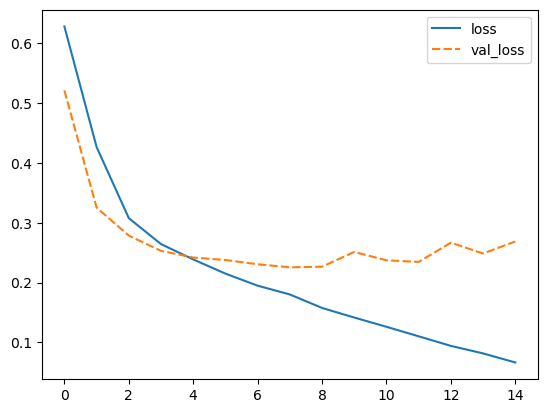

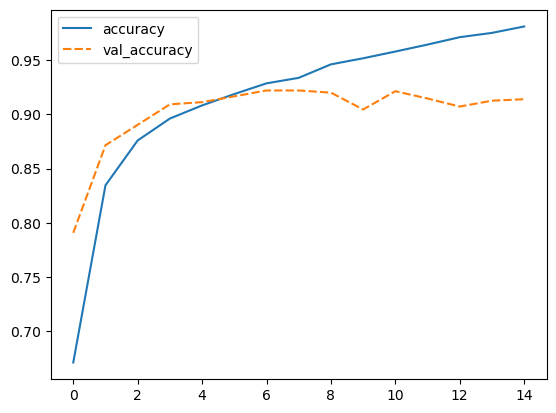

In [88]:
# plot loss history using seaborn

sns.lineplot(data=pd.DataFrame(history.history)[["loss", "val_loss"]])
plt.show()

# plot accuracy history using seaborn
sns.lineplot(data=pd.DataFrame(history.history)[["accuracy", "val_accuracy"]])
plt.show()

In [89]:
model.evaluate(test_gen)

3/3 [==============================] - 1s 310ms/step - loss: 0.2692 - accuracy: 0.9112


[0.2691899538040161, 0.9112426042556763]